In [96]:
import torch 
import torchvision
import torch.nn as nn 
import matplotlib.pyplot as plt
from pathlib import Path

In [138]:
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from tqdm import tqdm

In [98]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [99]:
!nvidia-smi

Sun Aug  4 15:49:43 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 556.12                 Driver Version: 556.12         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti   WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   56C    P0             17W /   50W |    3749MiB /   4096MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [100]:
data_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.Grayscale(1),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.ToTensor()
])

In [101]:
path = Path('###########')

In [102]:
train_dir = path / 'train'
test_dir = path /'test'

In [103]:
train_dir, test_dir

(WindowsPath('C:/Users/bhatt/OneDrive/Desktop/Face Recognition/img/train'),
 WindowsPath('C:/Users/bhatt/OneDrive/Desktop/Face Recognition/img/test'))

In [104]:
trainFolder = ImageFolder(train_dir, data_transform, target_transform=None)
testFolder = ImageFolder(test_dir, data_transform, target_transform=None)

In [105]:
len(trainFolder), len(testFolder)

(20, 13)

In [106]:
class_id = trainFolder.class_to_idx
class_dict = trainFolder.classes

class_id, class_dict

({'Subrat': 0, 'Unknown': 1}, ['Subrat', 'Unknown'])

In [107]:
import os

In [108]:
trainData = DataLoader(trainFolder, shuffle=True, num_workers= os.cpu_count(), batch_size=4)
testData = DataLoader(testFolder, num_workers= os.cpu_count(), batch_size=4)

In [133]:
class FaceModel(nn.Module):
    def __init__(self, inshape = 1, hidden_shape = 16, out_shape = 2):
        super(FaceModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(inshape, hidden_shape, kernel_size=2, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=1),
            nn.Dropout(0.2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(hidden_shape, hidden_shape, kernel_size=2, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=1),
            nn.Dropout(0.2)
        )
        self.layer3 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_shape * 256 * 256, out_shape)
        )


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x


In [134]:
model = FaceModel(inshape=1, hidden_shape=16, out_shape=2).to(device)

torch.Size([4, 1, 256, 256])

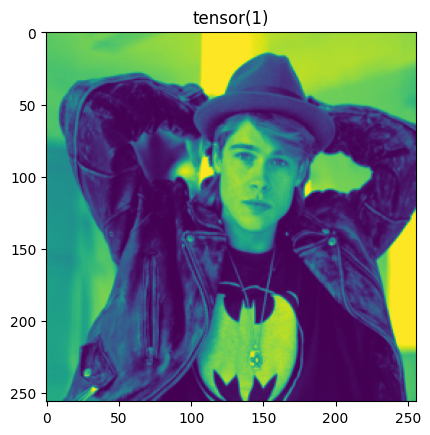

In [121]:
img, label = next(iter(trainData))
plt.title(label=label[0])
plt.imshow(img[0].permute(1,2,0))
plt.plot()
img.shape

In [136]:
pred = model(img.to(device))

In [141]:
from torchmetrics import Accuracy

In [142]:
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001)
acc = Accuracy('BINARY', num_classes=2)

In [155]:
import cv2
from PIL import Image

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')


In [152]:
epochs = 10

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for batch in tqdm(trainData):
        X,y = batch
        y_pred = model(X.to(device))
        optim.zero_grad()
        loss = loss_fn(y_pred.to(device), y.to(device))
        loss.backward()
        optim.step()
        total_train_loss += loss.item()
    total_train_loss /= len(trainData)


    model.eval()
    test_loss = 0
    test_acc = 0
    with torch.inference_mode():
        for batch in tqdm(testData):
            X, y = batch
            y_pred = model(X.to(device))
            loss = loss_fn(y_pred.to(device), y.to(device))
            test_loss += loss.item()
            test_acc += acc(y_pred.argmax(dim = 1).to('cpu'), y.to('cpu'))

        total_test_loss = test_loss / len(testData)
        total_test_Acc = test_acc / len(testData)

    print(f'Epoch: {epoch + 1}, trainLoss: {total_train_loss}, test_loss: {total_test_loss}, test Acc: {total_test_Acc}')

100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Epoch: 1, trainLoss: 1.8298321379006665e-06, test_loss: 0.2127470076084137, test Acc: 0.9375


100%|██████████| 4/4 [00:08<00:00,  2.20s/it]


Epoch: 2, trainLoss: 6.396930839400739e-05, test_loss: 0.6996009349822998, test Acc: 0.875


100%|██████████| 4/4 [00:07<00:00,  1.86s/it]


Epoch: 3, trainLoss: 0.020830741117242722, test_loss: 0.6178426146507263, test Acc: 0.875


100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch: 4, trainLoss: 0.00030058492993703114, test_loss: 0.22667668759821957, test Acc: 0.875


100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch: 5, trainLoss: 1.251696460258245e-07, test_loss: 0.01796551978657135, test Acc: 1.0


100%|██████████| 4/4 [00:08<00:00,  2.03s/it]


Epoch: 6, trainLoss: 1.7881390590446244e-08, test_loss: 0.19488974660310987, test Acc: 0.9375


100%|██████████| 4/4 [00:08<00:00,  2.08s/it]


Epoch: 7, trainLoss: 5.960464122267695e-09, test_loss: 0.1330468424805531, test Acc: 0.9375


100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Epoch: 8, trainLoss: 0.0, test_loss: 0.1171724274454391, test Acc: 0.9375


100%|██████████| 4/4 [00:08<00:00,  2.07s/it]


Epoch: 9, trainLoss: 0.0, test_loss: 0.0015700128670914637, test Acc: 1.0


100%|██████████| 4/4 [00:07<00:00,  2.00s/it]

Epoch: 10, trainLoss: 0.0, test_loss: 0.0011078881875619118, test Acc: 1.0


In [175]:
torch.save(model.state_dict(), 'faceRecognition.pt')

In [174]:
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # Convert BGR frame to RGB
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Convert NumPy array to PIL Image
    pil_image = Image.fromarray(rgb_frame)
    
    # Apply transformations
    transformed_image = data_transform(pil_image)
    
    # Add batch dimension and make a prediction
    input_tensor = transformed_image.unsqueeze(0).to(device)  # Add batch dimension and move to device
    with torch.no_grad():
        y_pred = model(input_tensor)

    # Get the predicted class
    predicted_class = y_pred.argmax(dim=1).item()
    # Convert prediction to string for display
    y_pred_str = str(class_dict[predicted_class])
    
    # Display the prediction on the frame
    cv2.putText(frame, y_pred_str, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.imshow('Face Recognition', frame)

    # Break the loop if the user presses 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()